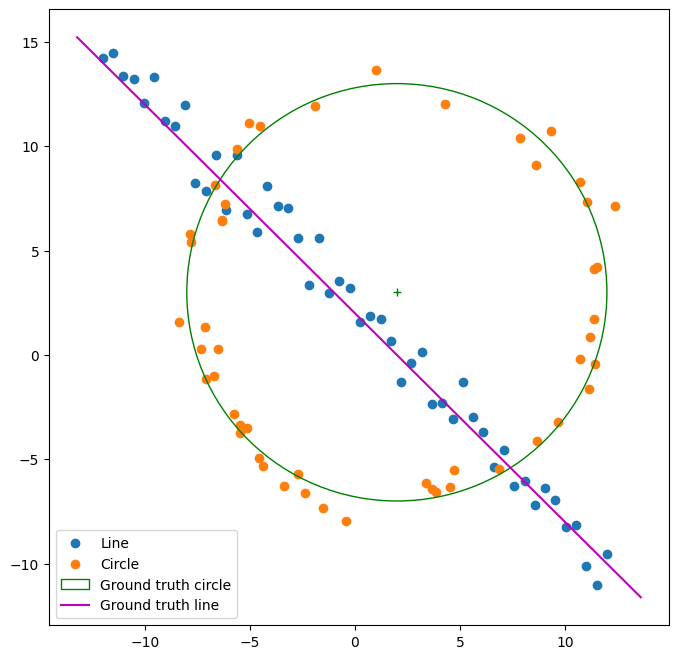

In [121]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

t = np.random.uniform(0, 2*np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)

X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s * np.random.randn(half_n)

X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()




Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3147398142807372e-11
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
res.x:  [0.87563464 0.48297411 4.76530967]
iteration =  0  , No. inliers =  12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.6231631002989392e-08
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
res.x:  [-0.32742005  0.94487891  2.6810103 ]
iteration =  1  , No. inliers =  8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.938965208840776e-10
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 8
res.x:  [ 0.99711359  0.07592561 -7.14989543]
iteration =  2  , No. inliers =  11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.294532791688782e-14
         

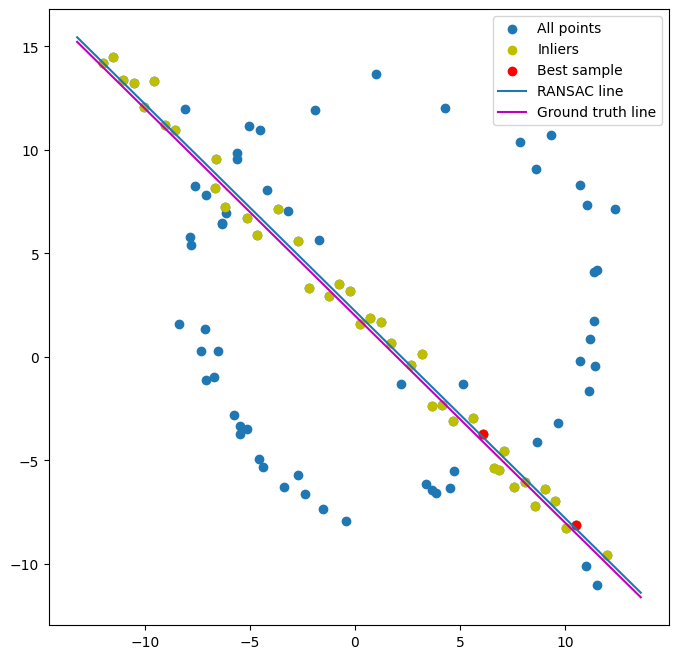

In [124]:
import math
from scipy.optimize import minimize

N = X.shape[0]
X_ = X

def line_equation_from_points(x1,y1,x2,y2):
    #Calculate the direction vector (delta_x,delta_y)
    delta_x = x2 - x1
    delta_y = y2 - y1

    #Calculate normalized vactor (a,b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    #Calculate d
    d = (a*x1) + (b*y1)

    #return the line equation in the form of ax+ by = d
    return a,b,d

# RANSAC to fit a line
def line_tls(x , indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))


#Constraint 
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

#Computing the consensus (inliers)
def consensus_line(X_,x,t):
    a, b, d = x[0], x[1], x[2]
    error  = np.abs(a*X_[:,0] + b*X_[:,1] - d)
    return error<t

t = 1 #Threshold value to determine data points that are fitted well by model
d = 0.4*N #Number of close data points required to assert that a model fits well to data
s = 2

inliers_line = [] # Indices of the inliers
max_iterations = 50
iteration = 0
best_model_line = [] # Best model normal to (a,b) and distance from origin d
best_error = np.inf
best_sample_line = [] # Three point sample leading to the best model computation
res_only_with_sample = [] # Result (a,b,d) only using the best sample
best_inliers_line = [] # Inliers using the best sample

while iteration < max_iterations:
    indices = np.random.randint(0,N,s)
    x0 = np.array([1,1,0]) # initial estimate
    res = minimize(fun = line_tls, args=(indices), x0 = x0, tol = 1e-6, constraints=cons, options = {'disp':True})
    inliers_line = consensus_line(X_,res.x,t) #computing inliers
    print('res.x: ',res.x)
    print('iteration = ', iteration, ' , No. inliers = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        #computing the new model using all inliers
        res = minimize(fun=line_tls, args=inliers_line, x0 = x0, tol = 1e-6, constraints=cons, options = {'disp':True})
        print(res.x, res.fun)
        if res.fun < best_error:
            print("A better model is found ...", res.x, res.fun)
            best_model_line = res.x
            best_error = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line
    iteration += 1
print("Best line model" , best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_[:,0],X_[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

In [158]:
# Get the indices of the inliers
inlier_indices = np.where(best_inliers_line)[0]

# Subtracting the consensus of the best line (removing inliers)
remnant_indices = np.setdiff1d(np.arange(N), inlier_indices)

# Extracting the remnant points
X_ = X[remnant_indices]
N = X_.shape[0]

def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / d
    uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / d
    r = np.sqrt(ux**2 + uy**2 + ((x1**2 + y1**2) * (x2 * y3 - x3 * y2) + (x2**2 + y2**2) * (x3 * y1 - x1 * y3) + (x3**2 + y3**2) * (x1 * y2 - x2 * y1)) / d)
    return ux, uy, r

# RANSAC to fit a circle
def circle_tls(x, indices):
    ux, uy, r = x[0], x[1], x[2]
    radial_errors = np.abs(np.sqrt((X_[indices, 0] - ux)**2 + (X_[indices, 1] - uy)**2) - r)
    return np.sum(np.square(radial_errors))


def consensus_circle(X, x, t):
    ux, uy, r = x[0], x[1], x[2]
    radial_error = np.abs(np.sqrt((X[:, 0] - ux)**2 + (X[:, 1] - uy)**2) - r)
    return radial_error < t

# Constraint for circle parameters
def h(x):
    return x[2] - 10

circle_cons = ({'type': 'ineq', 'fun': h})

# Threshold value to determine inliers (radial error)
t_circle = 1.0

# Number of close data points required to assert that a model fits well to data (circle)
d_circle = 0.3 * X_.shape[0]

inliers_circle = []
best_model_circle = []
best_inliers_circle = []
best_error_circle = np.inf
best_sample_circle = []

iteration = 0
max_iterations_circle = 50

s_circle = 3

while iteration < max_iterations_circle:
    indices_circ = np.random.randint(0,N, s_circle)
    x0_circle = circle_equation_from_points(X_[indices_circle[0], 0], X_[indices_circle[0], 1], X_[indices_circle[1], 0], X_[indices_circle[1], 1], X_[indices_circle[2], 0], X_[indices_circle[2], 1])
    res_circle = minimize(fun=circle_tls, args=(inliers_circle), x0=x0_circle, tol=1e-6, constraints=circle_cons)
    inliers_circle = consensus_circle(X_, res_circle.x, t_circle)
    print(f'Circle Iteration {iteration}, No. inliers = {inliers_circle.sum()}')
    if inliers_circle.sum() > d_circle:
        x0_circle = res_circle.x
        res_circle = minimize(fun=circle_tls, args=(inliers_circle), x0=x0_circle, tol=1e-6, constraints=circle_cons)
        if res_circle.fun < best_error_circle:
            print('A better model found ... ', res_circle.x, res_circle.fun)
            best_model_circle = res_circle.x
            best_error_circle = res_circle.fun
            best_inliers_circle = inliers_circle
            best_sample_circle = X_[indices_circle,:]
    iteration += 1

Circle Iteration 0, No. inliers = 27
A better model found ...  [ 1.90814871  3.35300651 10.        ] 4.905068640334193
Circle Iteration 1, No. inliers = 26
A better model found ...  [ 1.84325986  3.31760171 10.        ] 3.7474671593392075
Circle Iteration 2, No. inliers = 26
A better model found ...  [ 1.8432193   3.31760467 10.        ] 3.747467157051284
Circle Iteration 3, No. inliers = 26
Circle Iteration 4, No. inliers = 26
Circle Iteration 5, No. inliers = 26
Circle Iteration 6, No. inliers = 26
Circle Iteration 7, No. inliers = 26
Circle Iteration 8, No. inliers = 26
Circle Iteration 9, No. inliers = 26
Circle Iteration 10, No. inliers = 26
Circle Iteration 11, No. inliers = 26
Circle Iteration 12, No. inliers = 26
Circle Iteration 13, No. inliers = 26
Circle Iteration 14, No. inliers = 26
Circle Iteration 15, No. inliers = 26
Circle Iteration 16, No. inliers = 26
Circle Iteration 17, No. inliers = 26
Circle Iteration 18, No. inliers = 26
Circle Iteration 19, No. inliers = 26
Cir

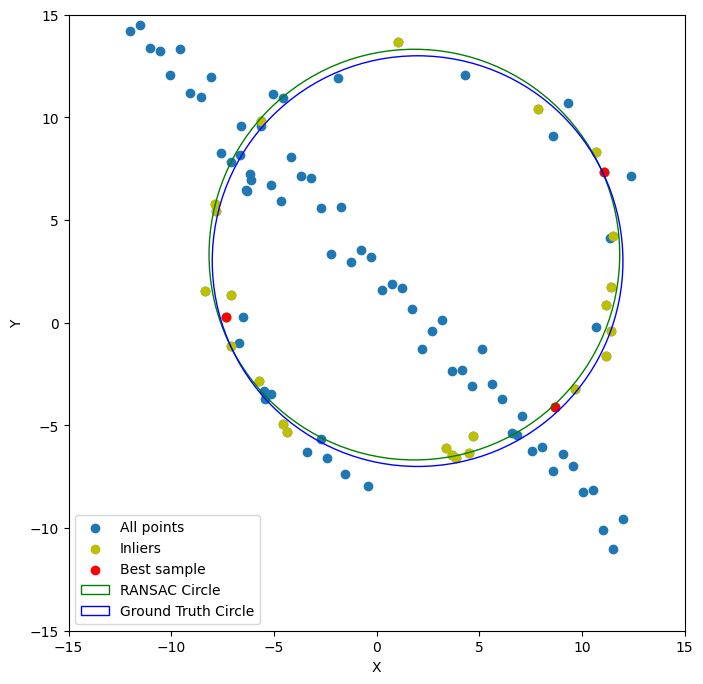

In [160]:
# Assuming best_model_circle contains [ux, uy, r]
ux, uy, r = best_model_circle

# Plotting the points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='All points')
ax.scatter(X_[best_inliers_circle, 0], X_[best_inliers_circle, 1], color='y', label='Inliers')
ax.scatter(best_sample_circle[:, 0], best_sample_circle[:, 1], color='r', label='Best sample')

# Plotting the RANSAC circle
circle_ransac = plt.Circle((ux, uy), r, color='g', fill=False, label='RANSAC Circle')
ax.add_patch(circle_ransac)

# Plotting the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='b', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)

# Set the aspect of the plot to be equal
ax.set_aspect('equal', 'box')

# Set limits and labels
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.xlabel('X')
plt.ylabel('Y')

plt.legend()
plt.show()


In [109]:
len(X)

100

In [110]:
X[0]

array([-6.51668467,  0.30278774])